In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from brukeropusreader import read_file
from scipy.interpolate import interp1d
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:


# Define folder paths
folder_path_oe = 'Spectra RE'
folder_path_re = 'Spectra OE'
folder_path_trachea = 'Spectra TR'

# Function to list files in a folder
def list_files(folder_path):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    return files

# List files in each folder
files_re = list_files(folder_path_re)
files_oe = list_files(folder_path_oe)
files_tr = list_files(folder_path_trachea)

# Displaying file names and their count
print("RE Folder:")
print(f"Number of files: {len(files_re)}")
print("Files:", files_re)





RE Folder:
Number of files: 210
Files: ['20240408 A5 OE.0004', '20240408 A5 OE.0003', '20240408 A2 OE.0001', '15012024 OE 4.0000', '15012024 OE 3.0012', '20240311 OE 1.0003', '19022024 OE 4.0004', '05022024 OE 1 mit max druck.0004', '20240415 B5 OE.0002', '20240415 B2 OE.0000', '20240311 OE 1.0004', '05022024 OE 1 mit max druck.0003', '20240318 OE A2.0000', '20240311 OE 5.0001', '19022024 OE 4.0003', '20240304 OE 3.0000', '15012024 OE 3.0013', '15012024 OE 4.0001', '15012024 OE 3.0014', '20240408 A5 OE.0002', '20240408 A2 OE.0000', '20240304 OE 3.0001', '20240311 OE 5.0000', '19022024 OE 4.0002', '20240318 OE A2.0001', '05022024 OE 1 mit max druck.0002', '20240415 B5 OE.0004', '20240311 OE 1.0002', '20240415 B5 OE.0003', '20240415 B2 OE.0001', '19022024 OE 1.0000', '19022024 OE 5.0002', '20240318 OE A3.0001', '05022024 OE 2 mit max druck.0002', '05022024 OE 5 mit max druck.0000', '20240408 A3 OE.0000', '20240408 A4 OE.0002', '20240304 OE 2.0001', '15012024 OE 1.0004', '15012024 OE 5.00

In [3]:

# Define the common set of wavenumbers
start_wavenumber = 5000  # Starting wavenumber
end_wavenumber = 400  # Ending wavenumber
resolution = 1  # Resolution in cm⁻¹

# Generate the common set of wavenumbers
common_wavenumbers = np.arange(start_wavenumber, end_wavenumber - resolution, -resolution)

# Verify the first and last values as well as the size of the set to ensure it matches expectations
print("First wavenumber:", common_wavenumbers[0])
print("Last wavenumber:", common_wavenumbers[-1])
print("Total number of points:", len(common_wavenumbers))

def get_wavenumbers(file_path):
    opus_data = read_file(file_path)
    num_points = len(opus_data['AB'])
    start_wn = opus_data['AB Data Parameter']['FXV']
    end_wn = opus_data['AB Data Parameter']['LXV']
    wavenumbers = np.linspace(start_wn, end_wn, num_points)
    return wavenumbers

def get_spectral_data(file_path):
    opus_data = read_file(file_path)
    spectral_data = opus_data['AB']
    return spectral_data

def interpolate_to_common_wavenumbers(file_path, common_wavenumbers):
    original_wavenumbers = get_wavenumbers(file_path)
    original_data = get_spectral_data(file_path)
    interpolation_func = interp1d(original_wavenumbers, original_data, kind='linear', fill_value="extrapolate")
    interpolated_data = interpolation_func(common_wavenumbers)
    return interpolated_data

def z_score_normalize(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    normalized_data = (data - mean) / std_dev
    return normalized_data

def process_directory(folder_path, common_wavenumbers):
    normalized_data_list = []
    files = list_files(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data = interpolate_to_common_wavenumbers(file_path, common_wavenumbers)
        mask = (common_wavenumbers >= 900) & (common_wavenumbers <= 1800)
        data = data[mask]
        normalized_data = z_score_normalize(data)
        normalized_data_list.append(normalized_data)
    return np.array(normalized_data_list)

# Process directories
data_oe = process_directory(folder_path_oe, common_wavenumbers)
data_re = process_directory(folder_path_re, common_wavenumbers)
data_trachea = process_directory(folder_path_trachea, common_wavenumbers)




First wavenumber: 5000
Last wavenumber: 400
Total number of points: 4601


Epoch 1/1000


/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3806 - loss: 2.2977 - val_accuracy: 0.3784 - val_loss: 1.0956
Epoch 2/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3480 - loss: 1.1977 - val_accuracy: 0.3784 - val_loss: 1.0931
Epoch 3/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3975 - loss: 1.1476 - val_accuracy: 0.3784 - val_loss: 1.0914
Epoch 4/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3607 - loss: 1.2125 - val_accuracy: 0.3784 - val_loss: 1.0912
Epoch 5/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3706 - loss: 1.0851 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 6/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3707 - loss: 1.0919 - val_accuracy: 0.3784 - val_loss: 1.0893
Epoch 7/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3886 - loss: 1.0842 - val_accuracy: 0.3784 - val_loss: 1.0890
Epoch 8/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4222 - loss: 1.0853 - val_accuracy: 0.3784 - val_l

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3902 - loss: 1.0874 - val_accuracy: 0.3784 - val_loss: 1.0891
Epoch 52/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3891 - loss: 1.0890 - val_accuracy: 0.3784 - val_loss: 1.0895
Epoch 53/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4120 - loss: 1.0886 - val_accuracy: 0.3784 - val_loss: 1.0902
Epoch 54/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3856 - loss: 1.0902 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 55/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3720 - loss: 1.0868 - val_accuracy: 0.3784 - val_loss: 1.0891
Epoch 56/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3909 - loss: 1.0806 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 57/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3717 - loss: 1.0854 - val_accuracy: 0.3784 - val_loss: 1.0895
Epoch 58/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3732 - loss: 1.0849 - val_accuracy: 0.3784 -

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4083 - loss: 1.0815 - val_accuracy: 0.3784 - val_loss: 1.0893
Epoch 102/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3890 - loss: 1.0833 - val_accuracy: 0.3784 - val_loss: 1.0897
Epoch 103/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4002 - loss: 1.0824 - val_accuracy: 0.3784 - val_loss: 1.0897
Epoch 104/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4012 - loss: 1.0834 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 105/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3977 - loss: 1.0875 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 106/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3685 - loss: 1.0936 - val_accuracy: 0.3784 - val_loss: 1.0891
Epoch 107/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4011 - loss: 1.0829 - val_accuracy: 0.3784 - val_loss: 1.0895
Epoch 108/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3494 - loss: 1.0946 - val_accuracy: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3992 - loss: 1.0890 - val_accuracy: 0.3784 - val_loss: 1.0895
Epoch 152/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3893 - loss: 1.0860 - val_accuracy: 0.3784 - val_loss: 1.0896
Epoch 153/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3603 - loss: 1.1004 - val_accuracy: 0.3784 - val_loss: 1.0893
Epoch 154/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3873 - loss: 1.0825 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 155/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3984 - loss: 1.0835 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 156/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4232 - loss: 1.0826 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 157/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4095 - loss: 1.0792 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 158/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4084 - loss: 1.0820 - val_accuracy: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4139 - loss: 1.0833 - val_accuracy: 0.3784 - val_loss: 1.0895
Epoch 202/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4063 - loss: 1.0870 - val_accuracy: 0.3784 - val_loss: 1.0895
Epoch 203/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3729 - loss: 1.0939 - val_accuracy: 0.3784 - val_loss: 1.0892
Epoch 204/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3888 - loss: 1.0920 - val_accuracy: 0.3784 - val_loss: 1.0890
Epoch 205/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4001 - loss: 1.0857 - val_accuracy: 0.3784 - val_loss: 1.0890
Epoch 206/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3976 - loss: 1.0838 - val_accuracy: 0.3784 - val_loss: 1.0891
Epoch 207/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3603 - loss: 1.0898 - val_accuracy: 0.3784 - val_loss: 1.0890
Epoch 208/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3739 - loss: 1.0862 - val_accuracy: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4195 - loss: 1.0842 - val_accuracy: 0.3784 - val_loss: 1.0890
Epoch 252/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3894 - loss: 1.0910 - val_accuracy: 0.3784 - val_loss: 1.0891
Epoch 253/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3763 - loss: 1.0885 - val_accuracy: 0.3784 - val_loss: 1.0892
Epoch 254/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4024 - loss: 1.0814 - val_accuracy: 0.3784 - val_loss: 1.0895
Epoch 255/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4085 - loss: 1.0872 - val_accuracy: 0.3784 - val_loss: 1.0896
Epoch 256/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4301 - loss: 1.0711 - val_accuracy: 0.3784 - val_loss: 1.0898
Epoch 257/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3842 - loss: 1.0866 - val_accuracy: 0.3784 - val_loss: 1.0892
Epoch 258/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3575 - loss: 1.0950 - val_accuracy: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4184 - loss: 1.0807 - val_accuracy: 0.3784 - val_loss: 1.0896
Epoch 302/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4129 - loss: 1.0786 - val_accuracy: 0.3784 - val_loss: 1.0896
Epoch 303/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3289 - loss: 1.1015 - val_accuracy: 0.3784 - val_loss: 1.0891
Epoch 304/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3848 - loss: 1.0879 - val_accuracy: 0.3784 - val_loss: 1.0892
Epoch 305/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3991 - loss: 1.0818 - val_accuracy: 0.3784 - val_loss: 1.0895
Epoch 306/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4151 - loss: 1.0752 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 307/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4038 - loss: 1.0805 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 308/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3894 - loss: 1.0851 - val_accuracy: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3947 - loss: 1.0846 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 352/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3925 - loss: 1.0826 - val_accuracy: 0.3784 - val_loss: 1.0895
Epoch 353/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4144 - loss: 1.0859 - val_accuracy: 0.3784 - val_loss: 1.0896
Epoch 354/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3865 - loss: 1.0871 - val_accuracy: 0.3784 - val_loss: 1.0893
Epoch 355/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3831 - loss: 1.0930 - val_accuracy: 0.3784 - val_loss: 1.0893
Epoch 356/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3849 - loss: 1.0875 - val_accuracy: 0.3784 - val_loss: 1.0893
Epoch 357/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3721 - loss: 1.0949 - val_accuracy: 0.3784 - val_loss: 1.0891
Epoch 358/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3752 - loss: 1.0878 - val_accuracy: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3712 - loss: 1.0891 - val_accuracy: 0.3784 - val_loss: 1.0893
Epoch 402/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3799 - loss: 1.0844 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 403/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3772 - loss: 1.0871 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 404/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3547 - loss: 1.0933 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 405/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3875 - loss: 1.0843 - val_accuracy: 0.3784 - val_loss: 1.0899
Epoch 406/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3976 - loss: 1.0923 - val_accuracy: 0.3784 - val_loss: 1.0902
Epoch 407/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4060 - loss: 1.0843 - val_accuracy: 0.3784 - val_loss: 1.0898
Epoch 408/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4231 - loss: 1.0793 - val_accuracy: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3973 - loss: 1.0784 - val_accuracy: 0.3784 - val_loss: 1.0892
Epoch 452/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3540 - loss: 1.0940 - val_accuracy: 0.3784 - val_loss: 1.0889
Epoch 453/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4283 - loss: 1.0781 - val_accuracy: 0.3784 - val_loss: 1.0893
Epoch 454/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4062 - loss: 1.0759 - val_accuracy: 0.3784 - val_loss: 1.0892
Epoch 455/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3905 - loss: 1.0829 - val_accuracy: 0.3784 - val_loss: 1.0890
Epoch 456/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3779 - loss: 1.0914 - val_accuracy: 0.3784 - val_loss: 1.0891
Epoch 457/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3940 - loss: 1.0941 - val_accuracy: 0.3784 - val_loss: 1.0892
Epoch 458/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3945 - loss: 1.0812 - val_accuracy: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3903 - loss: 1.0880 - val_accuracy: 0.3784 - val_loss: 1.0891
Epoch 502/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3990 - loss: 1.0844 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 503/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4156 - loss: 1.0825 - val_accuracy: 0.3784 - val_loss: 1.0897
Epoch 504/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3979 - loss: 1.0848 - val_accuracy: 0.3784 - val_loss: 1.0896
Epoch 505/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3805 - loss: 1.0899 - val_accuracy: 0.3784 - val_loss: 1.0893
Epoch 506/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4027 - loss: 1.0777 - val_accuracy: 0.3784 - val_loss: 1.0893
Epoch 507/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4002 - loss: 1.0893 - val_accuracy: 0.3784 - val_loss: 1.0892
Epoch 508/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3977 - loss: 1.0804 - val_accuracy: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4101 - loss: 1.0815 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 552/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3895 - loss: 1.0915 - val_accuracy: 0.3784 - val_loss: 1.0892
Epoch 553/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3838 - loss: 1.0886 - val_accuracy: 0.3784 - val_loss: 1.0891
Epoch 554/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3846 - loss: 1.0860 - val_accuracy: 0.3784 - val_loss: 1.0891
Epoch 555/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3992 - loss: 1.0856 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 556/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3541 - loss: 1.0975 - val_accuracy: 0.3784 - val_loss: 1.0893
Epoch 557/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3719 - loss: 1.0905 - val_accuracy: 0.3784 - val_loss: 1.0896
Epoch 558/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4046 - loss: 1.0797 - val_accuracy: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3965 - loss: 1.0789 - val_accuracy: 0.3784 - val_loss: 1.0890
Epoch 602/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4006 - loss: 1.0924 - val_accuracy: 0.3784 - val_loss: 1.0893
Epoch 603/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3896 - loss: 1.0849 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 604/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3545 - loss: 1.1046 - val_accuracy: 0.3784 - val_loss: 1.0892
Epoch 605/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4059 - loss: 1.0797 - val_accuracy: 0.3784 - val_loss: 1.0893
Epoch 606/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4069 - loss: 1.0749 - val_accuracy: 0.3784 - val_loss: 1.0893
Epoch 607/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3849 - loss: 1.0867 - val_accuracy: 0.3784 - val_loss: 1.0890
Epoch 608/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3990 - loss: 1.0817 - val_accuracy: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3685 - loss: 1.0881 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 652/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4154 - loss: 1.0768 - val_accuracy: 0.3784 - val_loss: 1.0897
Epoch 653/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3762 - loss: 1.0970 - val_accuracy: 0.3784 - val_loss: 1.0895
Epoch 654/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3791 - loss: 1.0851 - val_accuracy: 0.3784 - val_loss: 1.0895
Epoch 655/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3956 - loss: 1.0865 - val_accuracy: 0.3784 - val_loss: 1.0896
Epoch 656/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4106 - loss: 1.0858 - val_accuracy: 0.3784 - val_loss: 1.0892
Epoch 657/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4155 - loss: 1.0817 - val_accuracy: 0.3784 - val_loss: 1.0890
Epoch 658/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3826 - loss: 1.0820 - val_accuracy: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4063 - loss: 1.0846 - val_accuracy: 0.3784 - val_loss: 1.0893
Epoch 702/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3517 - loss: 1.0979 - val_accuracy: 0.3784 - val_loss: 1.0890
Epoch 703/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4132 - loss: 1.0802 - val_accuracy: 0.3784 - val_loss: 1.0892
Epoch 704/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3892 - loss: 1.0804 - val_accuracy: 0.3784 - val_loss: 1.0893
Epoch 705/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4117 - loss: 1.0754 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 706/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4047 - loss: 1.0829 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 707/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4042 - loss: 1.0822 - val_accuracy: 0.3784 - val_loss: 1.0895
Epoch 708/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3809 - loss: 1.0769 - val_accuracy: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3750 - loss: 1.0915 - val_accuracy: 0.3784 - val_loss: 1.0895
Epoch 752/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4218 - loss: 1.0783 - val_accuracy: 0.3784 - val_loss: 1.0903
Epoch 753/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4065 - loss: 1.0820 - val_accuracy: 0.3784 - val_loss: 1.0902
Epoch 754/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3769 - loss: 1.0932 - val_accuracy: 0.3784 - val_loss: 1.0895
Epoch 755/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3926 - loss: 1.0839 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 756/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3883 - loss: 1.0858 - val_accuracy: 0.3784 - val_loss: 1.0890
Epoch 757/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4222 - loss: 1.0810 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 758/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4035 - loss: 1.0796 - val_accuracy: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4034 - loss: 1.0844 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 802/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3907 - loss: 1.0849 - val_accuracy: 0.3784 - val_loss: 1.0891
Epoch 803/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3616 - loss: 1.0933 - val_accuracy: 0.3784 - val_loss: 1.0890
Epoch 804/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4030 - loss: 1.0867 - val_accuracy: 0.3784 - val_loss: 1.0896
Epoch 805/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4012 - loss: 1.0804 - val_accuracy: 0.3784 - val_loss: 1.0897
Epoch 806/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4227 - loss: 1.0811 - val_accuracy: 0.3784 - val_loss: 1.0896
Epoch 807/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3753 - loss: 1.0918 - val_accuracy: 0.3784 - val_loss: 1.0890
Epoch 808/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4310 - loss: 1.0739 - val_accuracy: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3716 - loss: 1.0963 - val_accuracy: 0.3784 - val_loss: 1.0897
Epoch 852/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4018 - loss: 1.0839 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 853/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3843 - loss: 1.0887 - val_accuracy: 0.3784 - val_loss: 1.0893
Epoch 854/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3767 - loss: 1.0859 - val_accuracy: 0.3784 - val_loss: 1.0890
Epoch 855/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3971 - loss: 1.0813 - val_accuracy: 0.3784 - val_loss: 1.0890
Epoch 856/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3954 - loss: 1.0789 - val_accuracy: 0.3784 - val_loss: 1.0891
Epoch 857/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3965 - loss: 1.0956 - val_accuracy: 0.3784 - val_loss: 1.0892
Epoch 858/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3702 - loss: 1.0889 - val_accuracy: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3974 - loss: 1.0856 - val_accuracy: 0.3784 - val_loss: 1.0894
Epoch 902/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3772 - loss: 1.0884 - val_accuracy: 0.3784 - val_loss: 1.0892
Epoch 903/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3668 - loss: 1.0979 - val_accuracy: 0.3784 - val_loss: 1.0891
Epoch 904/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3864 - loss: 1.0857 - val_accuracy: 0.3784 - val_loss: 1.0893
Epoch 905/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3820 - loss: 1.0877 - val_accuracy: 0.3784 - val_loss: 1.0892
Epoch 906/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3986 - loss: 1.0807 - val_accuracy: 0.3784 - val_loss: 1.0893
Epoch 907/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4490 - loss: 1.0676 - val_accuracy: 0.3784 - val_loss: 1.0897
Epoch 908/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4203 - loss: 1.0851 - val_accuracy: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3819 - loss: 1.0813 - val_accuracy: 0.3784 - val_loss: 1.0890
Epoch 952/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3902 - loss: 1.0847 - val_accuracy: 0.3784 - val_loss: 1.0891
Epoch 953/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4254 - loss: 1.0835 - val_accuracy: 0.3784 - val_loss: 1.0892
Epoch 954/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4092 - loss: 1.0868 - val_accuracy: 0.3784 - val_loss: 1.0890
Epoch 955/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3589 - loss: 1.0985 - val_accuracy: 0.3784 - val_loss: 1.0889
Epoch 956/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3790 - loss: 1.0953 - val_accuracy: 0.3784 - val_loss: 1.0890
Epoch 957/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3644 - loss: 1.0919 - val_accuracy: 0.3784 - val_loss: 1.0893
Epoch 958/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3995 - loss: 1.0888 - val_accuracy: 0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

          OE       0.00      0.00      0.00        47
          RE       0.33      1.00      0.50        37
     Trachea       0.00      0.00      0.00        27

    accuracy                           0.33       111
   macro avg       0.11      0.33      0.17       111
weighted avg       0.11      0.33      0.17       111



/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


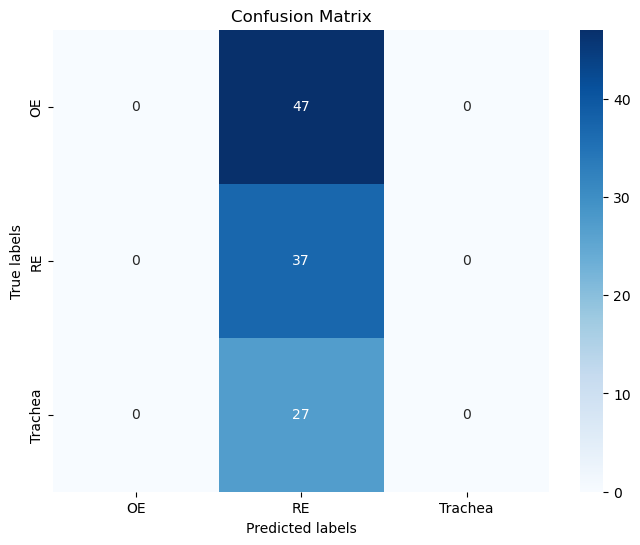

In [17]:

# Combine the average spectral data into one dataset and create labels
X = np.vstack([data_oe, data_re, data_trachea])
y = np.array([0] * len(data_oe) + [1] * len(data_re) + [2] * len(data_trachea))

# Split the data into a temporary training dataset and final test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary training dataset into actual training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Neural Network model training
def create_model(learning_rate=0.001, num_layers=3):
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    for _ in range(num_layers - 1):
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

learning_rate = 0.01
num_layers = 4

model = create_model(learning_rate=learning_rate, num_layers=num_layers)
model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_test, y_pred, target_names=['OE', 'RE', 'Trachea']))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['OE', 'RE', 'Trachea'], yticklabels=['OE', 'RE', 'Trachea'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



In [14]:
# Überprüfen der verwendeten Wellenlängen nach dem Zuschnitt
used_wavenumbers = common_wavenumbers[(common_wavenumbers >= 900) & (common_wavenumbers <= 1800)]
print("Verwendete Wellenlängen:", used_wavenumbers)

# Überprüfen der Form der Trainingsdaten nach dem Zuschnitt
print("Shape der Trainingsdaten:", X_train.shape)
print("Erwartete Anzahl der Features (Wellenlängen):", len(used_wavenumbers))


Verwendete Wellenlängen: [1800 1799 1798 1797 1796 1795 1794 1793 1792 1791 1790 1789 1788 1787
 1786 1785 1784 1783 1782 1781 1780 1779 1778 1777 1776 1775 1774 1773
 1772 1771 1770 1769 1768 1767 1766 1765 1764 1763 1762 1761 1760 1759
 1758 1757 1756 1755 1754 1753 1752 1751 1750 1749 1748 1747 1746 1745
 1744 1743 1742 1741 1740 1739 1738 1737 1736 1735 1734 1733 1732 1731
 1730 1729 1728 1727 1726 1725 1724 1723 1722 1721 1720 1719 1718 1717
 1716 1715 1714 1713 1712 1711 1710 1709 1708 1707 1706 1705 1704 1703
 1702 1701 1700 1699 1698 1697 1696 1695 1694 1693 1692 1691 1690 1689
 1688 1687 1686 1685 1684 1683 1682 1681 1680 1679 1678 1677 1676 1675
 1674 1673 1672 1671 1670 1669 1668 1667 1666 1665 1664 1663 1662 1661
 1660 1659 1658 1657 1656 1655 1654 1653 1652 1651 1650 1649 1648 1647
 1646 1645 1644 1643 1642 1641 1640 1639 1638 1637 1636 1635 1634 1633
 1632 1631 1630 1629 1628 1627 1626 1625 1624 1623 1622 1621 1620 1619
 1618 1617 1616 1615 1614 1613 1612 1611 1610 1609 1